In [47]:
#数据读取 为了方便大家更好的理解数据，我们重命名为中文
import numpy  as np
import pandas as pd
import os
data      = pd.read_csv("账户交易信息.csv", encoding="gbk")
train     = pd.read_csv("训练集标签.csv", encoding="gbk")
user_info = pd.read_csv("账户静态信息.csv", encoding="utf-8")
test      = pd.read_csv("test_dataset.csv", encoding="utf-8")
data = data.rename({
                    'jylsxh': '交易流水序号',
                    'zhdh': '账户代号',
                    'dfzh': '对方账号',
                    'jdbz': '借贷标志',
                    'jyje': '交易金额',
                    'jyye': '交易余额',
                    'dfhh': '对方行号',
                    'jyrq': '交易日期',
                    'jysj': '交易时间',
                    'jyqd': '交易渠道',
                    'zydh': '摘要代号',
                    'jdbj': '借贷标记',
                    'zhye': '账户余额',
                    'dfmccd': '对方名称长度'}, axis=1
                  )

train    = train.rename({'zhdh': '账户代号', 
                         'black_flag': '标签'}, axis=1
                       )

user_info =  user_info.rename({'zhdh': '账户代号',
                               'khrq':'开户日期', 
                               'xb': '性别', 
                             'khjgdh':'开户机构代号'}, axis=1
                              )

test    =  test.rename({'zhdh': '账户代号'},axis=1)

In [51]:
# 对数据进行聚合
df = data.groupby(['账户代号','对方账号']).agg({'交易流水序号': pd.Series.nunique}).reset_index()
print('聚合数据总数:\n',df.shape)

# 剔除自己指向自己的节点
df = df[df['账户代号']!=df['对方账号']]
print('剔除后的数据:\n',df.shape)

聚合数据总数:
 (194263, 3)
剔除后的数据:
 (193576, 3)


In [67]:
####################################################################
#LPA 算法
print('LPA算法开始...')
from networkx.algorithms.community import asyn_lpa_communities as lpa
com = list(lpa(G))
#格式整理
df_com_lpa = pd.DataFrame()
for i in range(0,len(com)):
    d = pd.DataFrame({'Group_id':[i]*len(com[i]),'账户代号':list(com[i])})
    df_com_lpa = pd.concat([df_com_lpa,d])


LPA算法开始...


In [52]:
# 算法分群模块
import networkx as nx
import matplotlib.pyplot as plt

# 常规-图数据转换
da = df[['账户代号','对方账号']].values
G  = nx.Graph()
for num in range(len(da)):
    G.add_edge(str(da[num,0]),str(da[num,1]))

####################################################################
#极大连通子图算法
print('极大连通子图...')
com = list(nx.connected_components(G))
#格式整理
df_com_connected  = pd.DataFrame()
for i in range(0, len(com)):
    d = pd.DataFrame({'Group_id': [i] * len(com[i]), '账户代号': list(com[i])})
    df_com_connected = pd.concat([df_com_connected,d])



极大连通子图...


In [63]:
#Louvain算法
print('Louvain算法...')
from community import community_louvain
com = community_louvain.best_partition(G)
#格式整理
df_com_louvain = pd.DataFrame()
df_com_louvain = pd.DataFrame({'Group_id':com.values(),
                               '账户代号':com.keys()}
                             )
print('计算结束')


Louvain算法...
计算结束


In [64]:
df_com_louvain

,Group_id,账户代号
0,0,00037295453A928A
1,0,0F76A363EACBDEAF
2,0,14BEFED1370B730A
3,0,1916F9D574C0979A
4,0,1F77C9FDBDBE78D0
...,...,...
137429,30,9A81823F2A29F2ED
137430,30,A3135BD31D25A2E3
137431,30,B7978165E63D78CB
137432,30,BC597FA783DBD1DD


In [65]:

# 分群结果概览
'''
团伙用户数统计 
df_com_connected
df_com_lpa
df_com_louvain
'''

df_com_louvain.groupby('Group_id').count().sort_values(by = '账户代号',ascending=False).head(200)

,账户代号
Group_id,
0,13155
2,12036
449,6026
172,3349
3,3073
...,...
284,67
443,67
44,66


In [30]:
#Louvain算法
print('Louvain算法...')
from community import community_louvain
com = community_louvain.best_partition(G)
#格式整理
df_com_louvain = pd.DataFrame()
df_com_louvain = pd.DataFrame({'Group_id':com.values(),
                               '账户代号':com.keys()}
                             )
print('计算结束')

Louvain算法...
计算结束


In [31]:
df_com_louvain

,Group_id,账户代号
0,0,02061001040024352
1,0,02060001040046109
2,0,02061001040026688
3,0,02061001940050310
4,0,02061401040004380
...,...,...
45803,19,8600009057000155
45804,19,867702001421000246
45805,19,8700115622421390000060
45806,19,912004010000050676


In [33]:

# 分群结果概览
'''
团伙用户数统计 
df_com_connected
df_com_lpa
df_com_louvain
'''

df_com_louvain.groupby('Group_id').count().sort_values(by = '账户代号',ascending=False).head(10)

,账户代号
Group_id,
26,4530
12,3398
1,2151
7,2002
18,1978
36,1950
13,1861
16,1804
35,1740


In [71]:
# 社群数据画像
'''
pandasql 可以把SQL代码写到这里，有些复杂的逻辑方便SQL写，
并且日常应用也好参考,
没有的安装下 pip install pandasql

# 交替看看三个算法的情况
df_com_connected
df_com_lpa
df_com_louvain

'''

from   pandasql import sqldf
query = '''
select 
group_id,
all_cnt,
test_cnt,
train_0_cnt,
train_1_cnt,
round(cast(train_1_cnt as double)/(train_0_cnt+train_1_cnt),4) as rate
from
(select
a.group_id,
count(a.账户代号)                        as all_cnt,
sum(case when 标签=0 then 1 else 0 end) as train_0_cnt,
sum(case when 标签=1 then 1 else 0 end) as train_1_cnt,
sum(case when c.账户代号 is not null then 1 else 0 end) as test_cnt
from
(select
group_id,
账户代号
from df_com_louvain -- 替换算法结果
) a
left join
(select
账户代号,
标签
from train
) b
on a.账户代号 = b.账户代号
left join
(select 
账户代号
from test
) c
on a.账户代号 = c.账户代号
group by group_id
) a
order by train_1_cnt desc
limit 2000
'''

sqldf(query).head(50)


,group_id,all_cnt,test_cnt,train_0_cnt,train_1_cnt,rate
0,0,13155,1417,299,77,0.2048
1,2,12036,718,146,20,0.1205
2,3,3073,83,4,20,0.8333
3,4,2396,148,24,20,0.4545
4,18,1621,77,8,10,0.5556
5,30,1510,36,5,9,0.6429
6,23,982,43,14,6,0.3000
7,11,2708,168,33,5,0.1316
8,59,726,22,0,5,1.0000
9,98,637,19,3,5,0.6250


In [72]:
# 交替看看三个算法的情况
'''
df_com_connected
df_com_lpa
df_com_louvain
'''

query = '''
select 
a.账户代号,
a.对方账号
from
(select 
账户代号,
对方账号
from df
)a

left join
(select
group_id,
账户代号
from df_com_louvain  --替换算法查看
where group_id=59
) b 
on a.账户代号 = b.账户代号

left join
(select
group_id,
账户代号
from df_com_louvain --替换算法查看
where group_id=59
) c 
on a.对方账号 = c.账户代号
where b.账户代号 is not null or c.账户代号 is not null
'''
dg = sqldf(query)

df_u_g = pd.DataFrame(pd.concat([dg['账户代号'],dg['对方账号']]))
df_u_g.columns = ['账户代号']


#节点来源处理
query = '''
select 
a.账户代号,
case when b.账户代号 is not null and 标签=1 then 'is_black_1' 
     when b.账户代号 is not null and 标签=0 then 'is_black_0' 
     when c.账户代号 is not null then 'is_test' else 'is_other' end  as flag
from
(select
账户代号
from df_u_g
group by 账户代号
) a
left join
(select
账户代号,
标签
from train
) b
on a.账户代号 = b.账户代号
left join
(select 
账户代号
from test
) c
on a.账户代号 = c.账户代号
'''

flag = sqldf(query)



In [74]:
flag.flag.value_counts()

is_other      709
is_test        22
is_black_1      5
Name: flag, dtype: int64

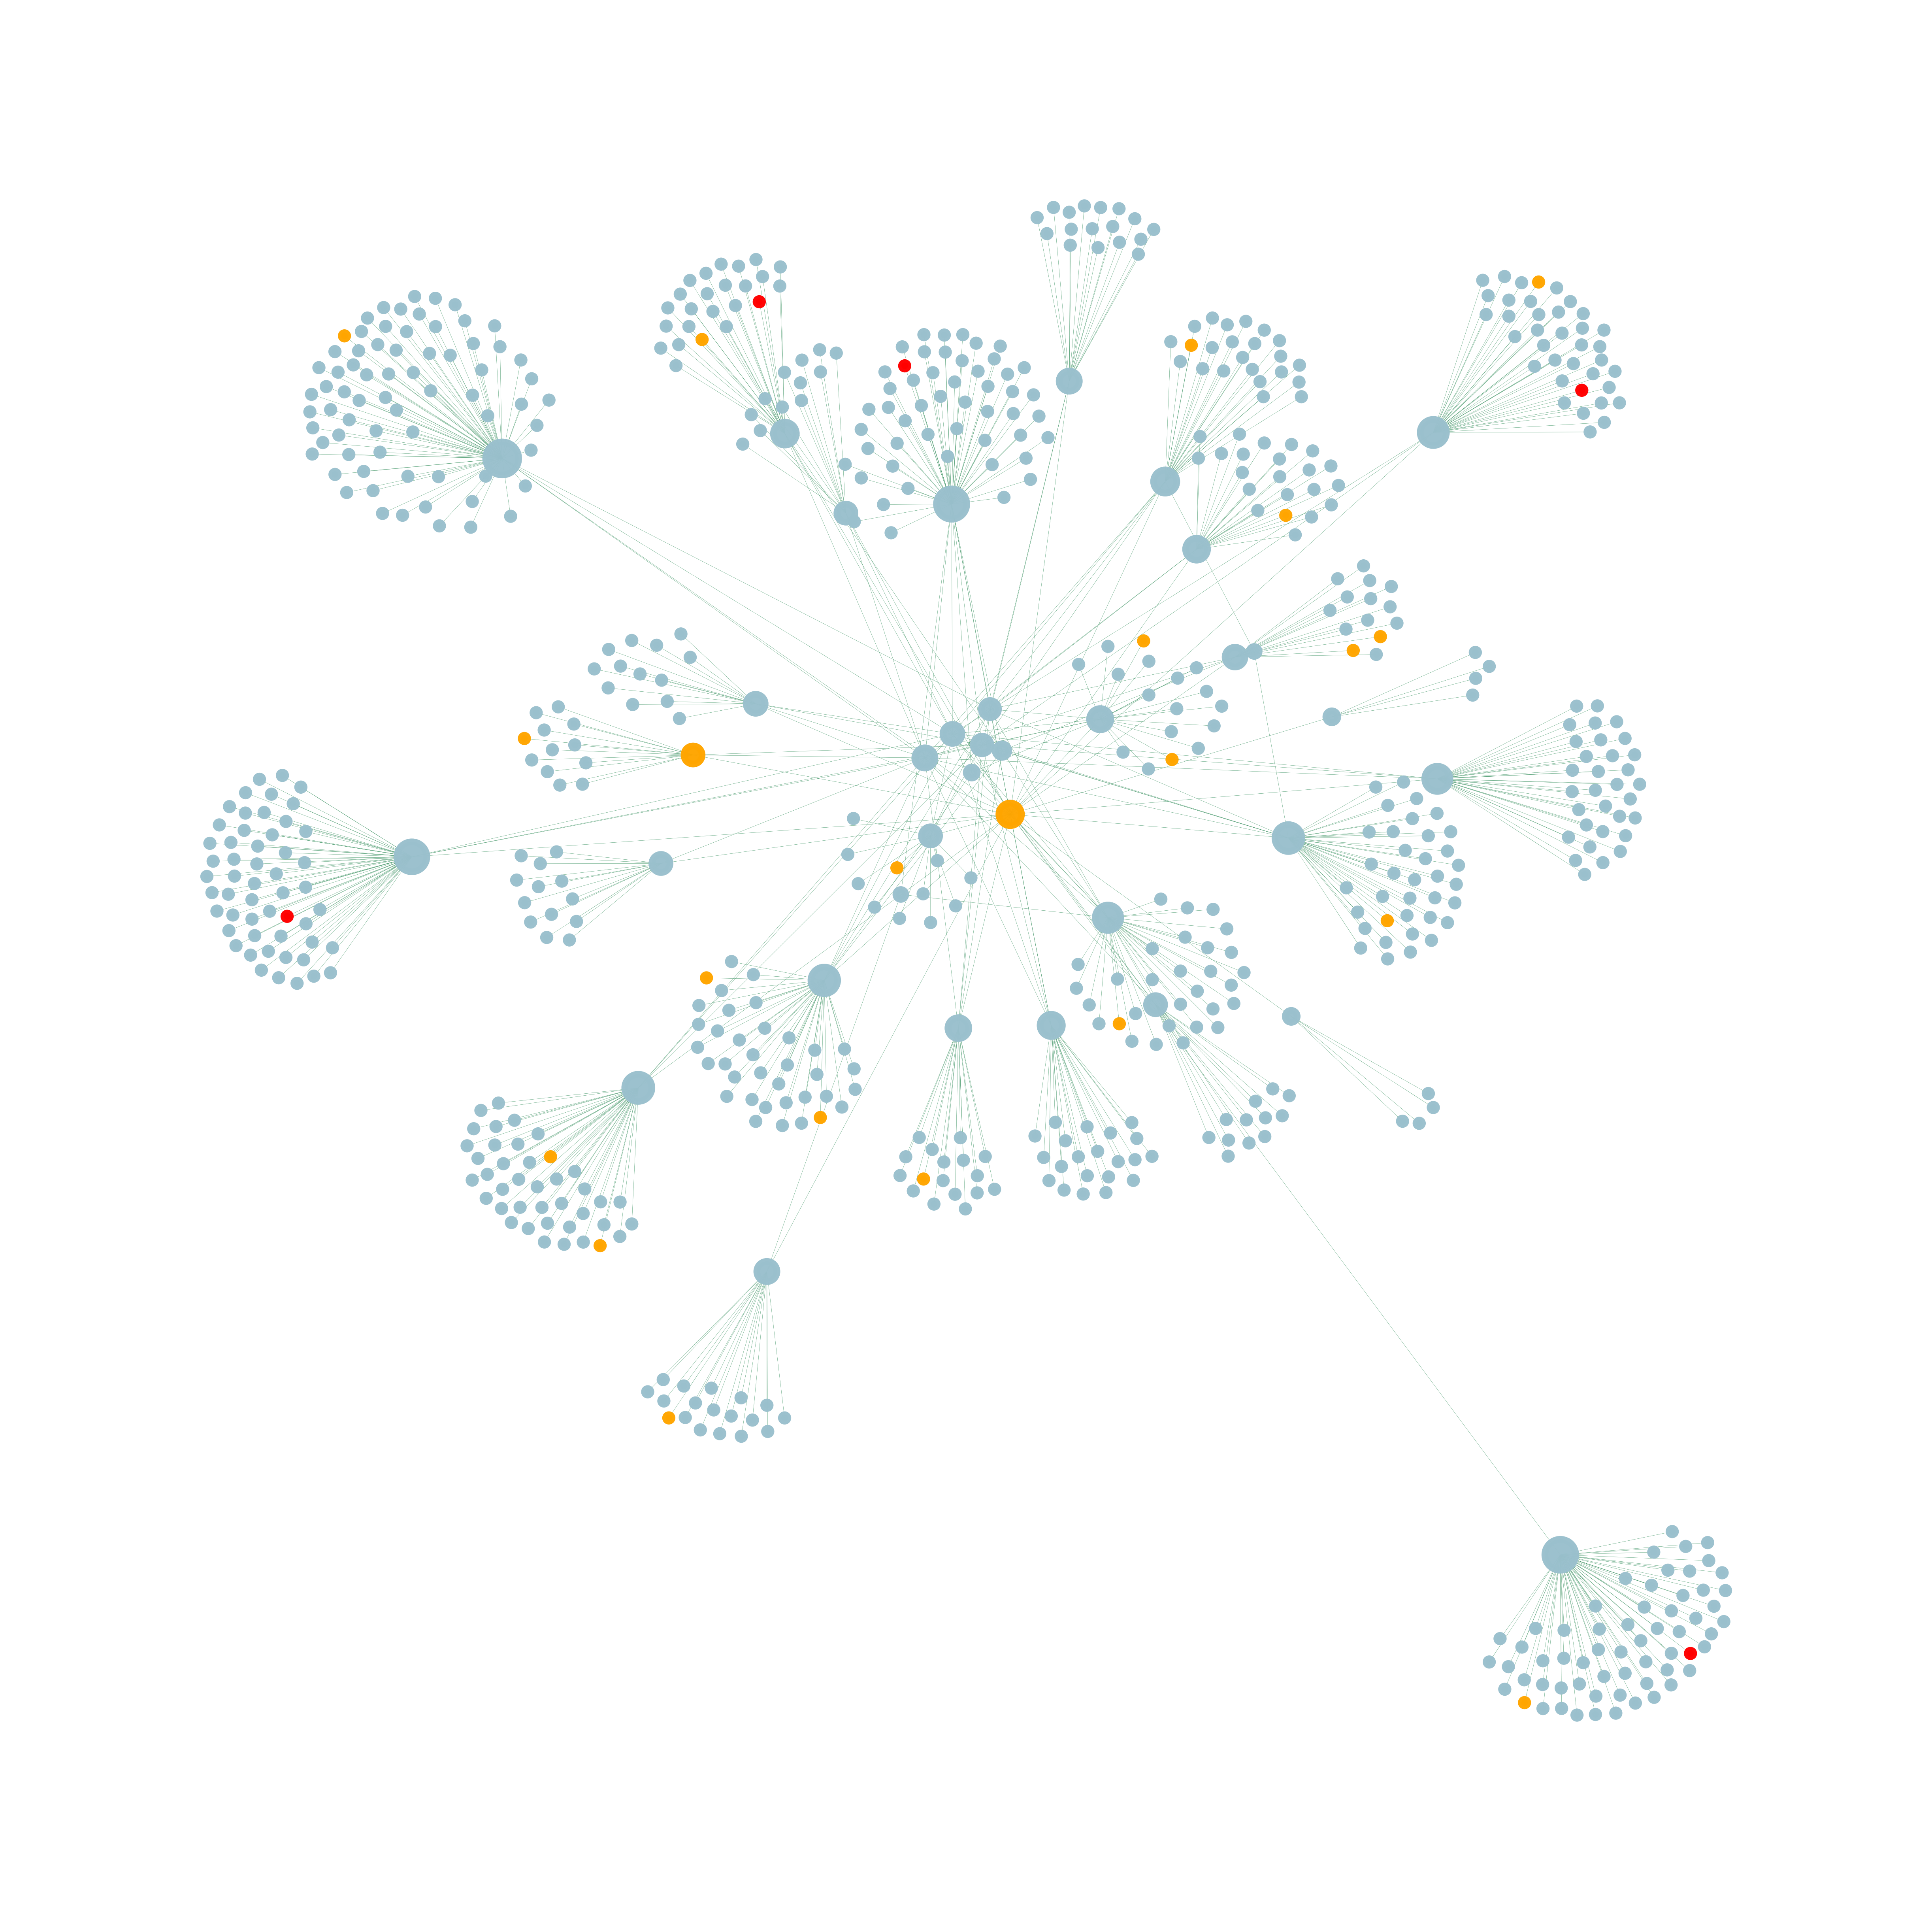

In [76]:

# 社区还原并可视化
da = dg[['账户代号','对方账号']].values
G  = nx.Graph()
for num in range(len(da)):
    G.add_edge(str(da[num,0]),str(da[num,1]))

#显示图片
plt.figure(figsize=(5,5),dpi=1200)


# 颜色设置
'''
训练集-黑样本  -- 红色 r
训练集-白羊本  -- 黑色 black
测试集 --------- 橘色 Orange
对手账户-------- 灰色
'''
colors_dic={'is_black_1':'r','is_black_0':'black','is_test':'Orange','is_other':'#9AC0CD'}

colors = flag['flag'].map(colors_dic).tolist()


#节点大小设置，与度关联
node_size = [G.degree(i)**0.75*1 for i in G.nodes()]


#kamada_kawai_layout spring_layout
nx.draw_networkx(G,
                 pos = nx.spring_layout(G),
                 node_color = colors,
                 edge_color = '#2E8B57',
                 with_labels=False,
                 #font_size = 0.01,
                 node_size = node_size,
                 alpha = 0.98,
                 width = 0.03
                 )
plt.axis('off')
plt.show()